In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Disable warnings, only print errors from Pinn.Pinn import get_models, get_v, get_D

from Pinn.Pinn import get_models, get_v, get_D, PINN, DenseNN
from Pinn.Training import train_custom, TrainingData
from Pinn.Plotting import plot_nn_colorbar

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

tf.get_logger().setLevel("ERROR")

--------------- Loaded PINN ---------------
GPU is available ['/physical_device:GPU:0']


In [2]:
R, T, N, = 1, 2*np.pi, 128
xs, ts = np.meshgrid(np.linspace(0., R, N), np.linspace(0., T, N))

In [3]:
@tf.function
def v_dynamic_tf(x, t):
    x = tf.reshape(x, (-1,))
    t = tf.reshape(t, (-1,))
    return tf.reshape(
        1./3. * np.pi * (1./2. + tf.sin(np.pi * x)**2) * tf.cos(t),
        (-1, 1))

def v_dynamic(x, t):
    return 1./3. * np.pi * (1./2. + np.sin(np.pi * x)**2) * np.cos(t)

def C_0(x):
    return np.exp(-400*(x - 0.1)**2)

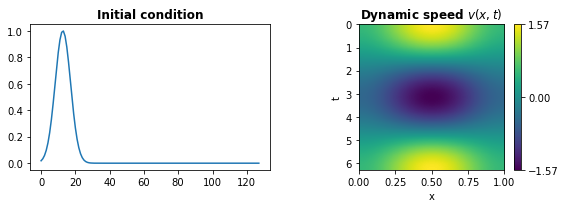

In [4]:
fig = plt.figure(figsize=(8, 3))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(121)
plt.title('Initial condition', fontweight='bold')
plt.plot(C_0(xs[0]))

Z = 1./3. * np.pi * (1./2. + np.sin(np.pi * xs)**2) * np.cos(ts)

ax = fig.add_subplot(122)
im = ax.imshow(Z, extent=[0., R, T, 0.], aspect=R/T)
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.colorbar(im, ticks=[np.min(Z), 0, np.max(Z)], fraction=0.046, pad=0.04)
plt.title('Dynamic speed $v(x, t)$', fontweight='bold')

plt.tight_layout()
plt.show()

#### Framed Learning

In [5]:
def create_training_data(R_l, R, T_l, T, N,
                         num_ic_multiplier=128,
                         with_ic=True):
    # PDE: 128**2 training points
    xs_pde, ts_pde = np.meshgrid(np.linspace(R_l, R, N+2)[1:-1],
                                 np.linspace(T_l, T, N+2)[1:-1])
    xs_pde, ts_pde = xs_pde.reshape(-1, 1), ts_pde.reshape(-1, 1)
    x_train = [tf.concat((xs_pde, ts_pde), axis=1)]
    y_train = [tf.zeros(shape=xs_pde.shape, dtype=tf.float32)]
    
    # Initial condition exactly num*N
    if with_ic:
        m = 4
        xs_ic = np.tile(np.linspace(R_l, R, int(128/m*N), dtype=np.float32), m)[:, None]
        ts_ic = np.zeros(shape=(num_ic_multiplier*N, 1), dtype=np.float32)
        x_train.append(tf.concat((xs_ic, ts_ic), axis=1))
        y_train.append(tf.constant(C_0(xs_ic), dtype=tf.float32))
    
    return TrainingData(x_train, y_train, batch_size=16384)
print('Create Training Data Function Definition')

Create Training Data Function Definition


In [6]:
R, T, N, = 1.2, 2*np.pi, 128

In [7]:
model, pinn_ic, pinn_pde = get_models(D={'trainable': False, 'value': 0.0},
                                         v={'trainable': False,
                                            'value': v_dynamic_tf },
                                         # 'value': tf.cast(v_dynamic_tf(
                                         #     training_data[0].x_train[0][..., 0], training_data[0].x_train[0][..., 1]),
                                         #                  tf.float32)},
                                         with_data=False)

In [8]:
training_data = [
    create_training_data(R_l=-0.2, R=R, T_l=0, T=2., N=N, with_ic=True),
    # create_training_data(R=R, T_l=0.5, T=2.5, N=N, with_ic=False),
    create_training_data(R_l=-0.2, R=R, T_l=0, T=3., N=N, with_ic=True),
    # #create_training_data(R=R, T_l=1.5, T=5., N=N, with_ic=False),
    create_training_data(R_l=-0.2, R=R, T_l=0, T=2*np.pi, N=N, with_ic=True),
]

Epoch 4999 / [==================================================>] 0.00006 [Batch  0]
[106.86s] Loss: 0.02258 --> 0.00006


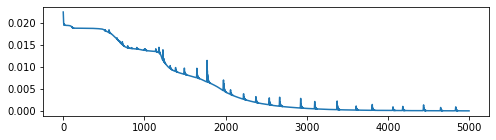

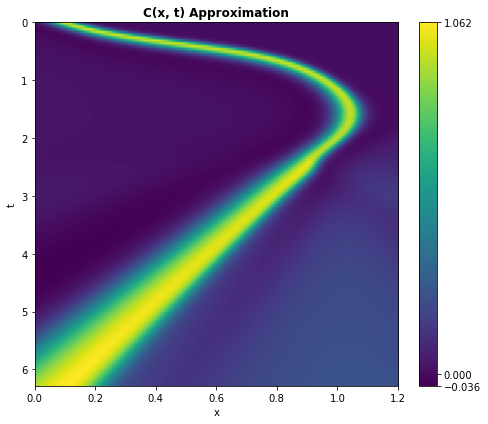

In [9]:
losses = train_custom(pinn_ic, training_data[0],
                      tf.keras.optimizers.Adam(learning_rate=1e-3),
                      epochs=5000)
plt.figure(figsize=(8, 2))
plt.plot(losses)
plt.show()
plot_nn_colorbar(model, R, T, N)

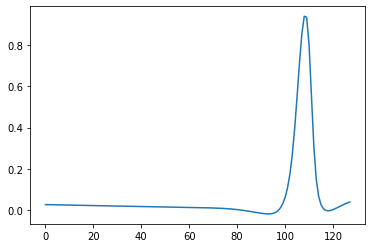

In [10]:
plt.plot(model(np.concatenate(
    (np.linspace([-0.2], [R], N), np.full((N, 1), 2)), axis=1
)))

Epoch 2999 / [==================================================>] 0.00039 [Batch  0]
[64.44s] Loss: 0.38512 --> 0.00039


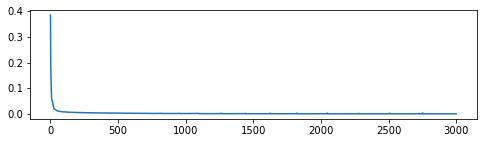

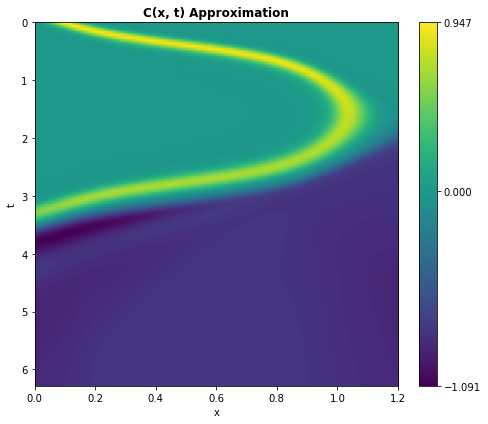

In [11]:
losses = train_custom(pinn_ic, training_data[1],
                      tf.keras.optimizers.Adam(learning_rate=1e-3),
                      epochs=3000)
plt.figure(figsize=(8, 2))
plt.plot(losses)
plt.show()
plot_nn_colorbar(model, R, T, N)

Epoch 2999 / [==================================================>] 0.00010 [Batch  0]
[63.92s] Loss: 0.01739 --> 0.00010


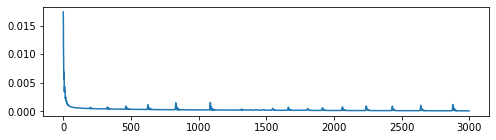

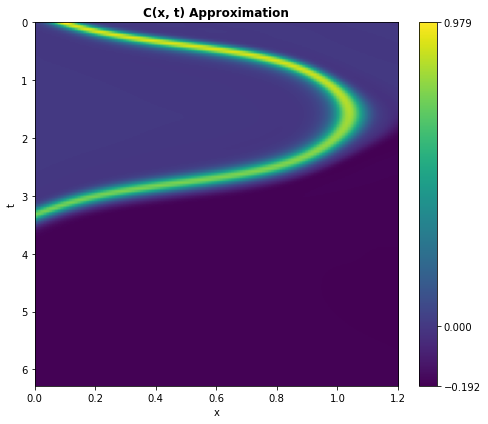

In [12]:
losses = train_custom(pinn_ic, training_data[2],
                      tf.keras.optimizers.Adam(learning_rate=1e-3),
                      epochs=3000)
plt.figure(figsize=(8, 2))
plt.plot(losses)
plt.show()
plot_nn_colorbar(model, R, T, N)